In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name = 'NanumGothic'
)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({
    "font.size" : 10,
    "font.family" : 'NanumGothic'
})
plt.rc('font', family='NanumGothic')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime
from pathlib import Path
from tqdm.auto import tqdm

In [2]:
DATA = Path("../../Data")

In [3]:
train = pd.read_csv(DATA / "fog_train.csv")
test = pd.read_csv(DATA / "fog_test.csv")

In [4]:
del train["Unnamed: 0"]
del test["Unnamed: 0"]

In [5]:
train_origin_columns = train.columns
test_origin_columns = test.columns

In [6]:
train.columns = train.columns.str.replace("fog_train.", "")
test.columns = test.columns.str.replace("fog_test.", "")

In [7]:
# J 년도 11월 3일 18시 20분 EC지역 없음
new_data = dict(zip(train.columns, ["J", 11, 3, 18, 20, "EC", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]))
fill_df = pd.DataFrame(new_data, index=[0])
train = pd.concat([train, fill_df], ignore_index=True)

In [8]:
def create_datetime(data):
    if data[f"year"] == 'I' :
        return datetime.datetime(year=2020, month=data[f'month'], day=data[f'day'], 
                                 hour = data[f'time'], minute=data[f'minute'])
    elif data[f"year"] == 'J' :
        return datetime.datetime(year=2022, month=data[f'month'], day=data[f'day'], 
                                 hour = data[f'time'], minute=data[f'minute'])
    elif data[f"year"] == 'K' :
        return datetime.datetime(year=2024, month=data[f'month'], day=data[f'day'], 
                                 hour = data[f'time'], minute=data[f'minute'])
    elif data[f"year"] == 'L' :
        return datetime.datetime(year=2026, month=data[f'month'], day=data[f'day'], 
                                 hour = data[f'time'], minute=data[f'minute'])
    else :
        return np.nan

In [9]:
train["datetime"] = train.apply(create_datetime, axis=1)
test["datetime"] = test.apply(create_datetime, axis=1)

In [10]:
train = train.sort_values(by=["stn_id", "datetime"]).reset_index(drop=True)

In [11]:
null_list = [-99, -99., -99.9, -999]
train[train.isin(null_list)] = np.nan
test[test.isin(null_list)] = np.nan

In [12]:
train["vis1"] = train["vis1"].apply(lambda x : 20000 if x > 20000 else x)

In [13]:
def make_diff(data, mode='train'):
    if mode == 'train':
        target = ["ws10_deg", "ws10_ms", "ta", "re", "hm", "sun10", "ts", "vis1"]
    elif mode == 'test':
        target = ["ws10_deg", "ws10_ms", "ta", "re", "hm", "sun10", "ts"]
    else :
        raise
    
    points = data["stn_id"].unique() # 각 지점별 처리를 위한 지점 저장
    concated_df = pd.DataFrame()
    for point in tqdm(points): # 각 지점별 처리
        target_df = data[data["stn_id"]==f"{point}"].copy().reset_index(drop=True)
        for col in target:
            target_df[f"{col}_diff"] = target_df[f"{col}"].diff()
            target_df.loc[0, f"{col}_diff"] = 0.0 # 첫 차분값 0.0으로 설정
        concated_df = pd.concat([concated_df, target_df], axis=0).reset_index(drop=True)
    return concated_df

In [14]:
train = make_diff(data=train, mode='train')
test = make_diff(data=test, mode='test')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
def make_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    
    elif month >= 6 and month <= 8:
        return 'summer'
    
    elif month >= 9 and month <= 11:
        return 'autumn'
    
    elif month < 3 or month > 11:
        return 'winter'
    else:
        return np.nan

In [19]:
def make_four_time_type(time):
    if 0 <= time < 6:
        return "dawn"
    elif 6 <= time < 12:
        return "morning"
    elif 12 <= time < 18:
        return "afternoon"
    elif 18 <= time < 23:
        return "night"
    else:
        return np.nan

In [20]:
def make_eight_time_type(time):
    if 0 <= time < 3:
        return "early dawn"
    elif 3 <= time < 6:
        return "late dawn"
    elif 6 <= time < 9:
        return "early morning"
    elif 9 <= time < 12:
        return "late morning"
    elif 12 <= time < 15:
        return "early afternoon"
    elif 15 <= time < 18:
        return "late afternoon"
    elif 18 <= time < 21:
        return "early night"
    elif 21<= time <=23:
        return "late night"
    else:
        return np.nan

In [21]:
train["season"] = train["month"].apply(make_season)
test["season"] = test["month"].apply(make_season)

In [22]:
train["ftt"] = train["time"].apply(make_four_time_type)
train["ett"] = train["time"].apply(make_eight_time_type)
test["ftt"] = test["time"].apply(make_four_time_type)
test["ett"] = test["time"].apply(make_eight_time_type)

In [23]:
train_I = train.loc[train["year"]=="I", : ].set_index("datetime").reset_index()
train_J = train.loc[train["year"]=="J", : ].set_index("datetime").reset_index()
train_K = train.loc[train["year"]=="K", : ].set_index("datetime").reset_index()

In [24]:
train_I

,datetime,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,...,ws10_ms_diff,ta_diff,re_diff,hm_diff,sun10_diff,ts_diff,vis1_diff,season,ftt,ett
0,2020-01-01 00:10:00,I,1,1,0,10,AA,0.0,0.0,-6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter,dawn,early dawn
1,2020-01-01 00:20:00,I,1,1,0,20,AA,0.0,0.0,-6.3,...,0.0,0.1,0.0,-1.0,0.0,0.1,0.0,winter,dawn,early dawn
2,2020-01-01 00:30:00,I,1,1,0,30,AA,0.0,0.0,-6.3,...,0.0,0.0,0.0,2.1,0.0,0.1,0.0,winter,dawn,early dawn
3,2020-01-01 00:40:00,I,1,1,0,40,AA,27.8,0.4,-6.2,...,0.4,0.1,0.0,-0.5,0.0,0.0,0.0,winter,dawn,early dawn
4,2020-01-01 00:50:00,I,1,1,0,50,AA,59.7,0.5,-6.1,...,0.1,0.1,0.0,0.3,0.0,0.1,0.0,winter,dawn,early dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054055,2020-12-31 23:10:00,I,12,31,23,10,EC,260.9,5.9,-0.3,...,-0.1,0.1,0.0,-0.2,0.0,0.1,0.0,winter,NaN,late night
1054056,2020-12-31 23:20:00,I,12,31,23,20,EC,264.3,5.5,-0.3,...,-0.4,0.0,0.0,-0.5,0.0,0.0,0.0,winter,NaN,late night
1054057,2020-12-31 23:30:00,I,12,31,23,30,EC,258.7,5.3,-0.2,...,-0.2,0.1,0.0,-0.2,0.0,0.4,0.0,winter,NaN,late night
1054058,2020-12-31 23:40:00,I,12,31,23,40,EC,263.6,5.7,-0.1,...,0.4,0.1,0.0,0.4,0.0,0.2,0.0,winter,NaN,late night


In [25]:
train_J

,datetime,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,...,ws10_ms_diff,ta_diff,re_diff,hm_diff,sun10_diff,ts_diff,vis1_diff,season,ftt,ett
0,2022-01-01 00:00:00,J,1,1,0,0,AA,245.9,1.8,-8.3,...,-0.4,-0.1,0.0,0.3,0.0,NaN,0.0,winter,dawn,early dawn
1,2022-01-01 00:10:00,J,1,1,0,10,AA,271.1,2.0,-8.4,...,0.2,-0.1,0.0,0.3,0.0,NaN,0.0,winter,dawn,early dawn
2,2022-01-01 00:20:00,J,1,1,0,20,AA,258.2,2.1,-8.4,...,0.1,0.0,0.0,0.4,0.0,NaN,0.0,winter,dawn,early dawn
3,2022-01-01 00:30:00,J,1,1,0,30,AA,261.3,2.1,-8.5,...,0.0,-0.1,0.0,0.4,0.0,NaN,0.0,winter,dawn,early dawn
4,2022-01-01 00:40:00,J,1,1,0,40,AA,256.9,2.5,-8.5,...,0.4,0.0,0.0,0.5,0.0,NaN,0.0,winter,dawn,early dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051195,2022-12-31 23:10:00,J,12,31,23,10,EC,312.8,7.1,-2.3,...,-0.1,-0.1,0.0,-1.1,0.0,0.0,0.0,winter,NaN,late night
1051196,2022-12-31 23:20:00,J,12,31,23,20,EC,315.3,7.2,-2.3,...,0.1,0.0,0.0,-1.1,0.0,-0.1,0.0,winter,NaN,late night
1051197,2022-12-31 23:30:00,J,12,31,23,30,EC,315.6,7.2,-2.3,...,0.0,0.0,0.0,-0.8,0.0,0.1,0.0,winter,NaN,late night
1051198,2022-12-31 23:40:00,J,12,31,23,40,EC,312.3,7.2,-2.3,...,0.0,0.0,0.0,-0.9,0.0,-0.1,0.0,winter,NaN,late night


In [26]:
train_K

,datetime,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,...,ws10_ms_diff,ta_diff,re_diff,hm_diff,sun10_diff,ts_diff,vis1_diff,season,ftt,ett
0,2024-01-01 00:00:00,K,1,1,0,0,AA,317.5,1.9,-8.5,...,0.2,0.1,0.0,0.2,0.0,NaN,0.0,winter,dawn,early dawn
1,2024-01-01 00:10:00,K,1,1,0,10,AA,304.4,1.9,-8.6,...,0.0,-0.1,0.0,-0.3,NaN,NaN,0.0,winter,dawn,early dawn
2,2024-01-01 00:20:00,K,1,1,0,20,AA,273.2,2.2,-8.7,...,0.3,-0.1,0.0,0.0,NaN,NaN,0.0,winter,dawn,early dawn
3,2024-01-01 00:30:00,K,1,1,0,30,AA,262.8,2.1,-8.9,...,-0.1,-0.2,0.0,0.7,0.0,NaN,0.0,winter,dawn,early dawn
4,2024-01-01 00:40:00,K,1,1,0,40,AA,257.4,2.3,-9.0,...,0.2,-0.1,0.0,-0.2,0.0,NaN,0.0,winter,dawn,early dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051195,2024-12-31 23:10:00,K,12,31,23,10,EC,305.3,7.7,2.5,...,1.1,0.1,0.0,-0.1,0.0,0.0,0.0,winter,NaN,late night
1051196,2024-12-31 23:20:00,K,12,31,23,20,EC,293.8,5.7,2.3,...,-2.0,-0.2,0.0,-0.1,0.0,-0.4,0.0,winter,NaN,late night
1051197,2024-12-31 23:30:00,K,12,31,23,30,EC,274.2,4.9,2.2,...,-0.8,-0.1,0.0,0.9,0.0,-0.1,0.0,winter,NaN,late night
1051198,2024-12-31 23:40:00,K,12,31,23,40,EC,270.3,4.6,2.1,...,-0.3,-0.1,0.0,0.7,0.0,-0.2,0.0,winter,NaN,late night


In [27]:
test = test.set_index("datetime").reset_index()

In [28]:
test

,datetime,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,...,ws10_deg_diff,ws10_ms_diff,ta_diff,re_diff,hm_diff,sun10_diff,ts_diff,season,ftt,ett
0,2026-01-01 00:00:00,L,1,1,0,0,AI,329.5,0.6,-2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter,dawn,early dawn
1,2026-01-01 00:10:00,L,1,1,0,10,AI,321.8,1.2,-2.5,...,-7.7,0.6,0.0,0.0,0.7,0.0,0.0,winter,dawn,early dawn
2,2026-01-01 00:20:00,L,1,1,0,20,AI,0.4,0.4,-2.5,...,-321.4,-0.8,0.0,0.0,0.4,0.0,-0.1,winter,dawn,early dawn
3,2026-01-01 00:30:00,L,1,1,0,30,AI,323.6,0.7,-2.6,...,323.2,0.3,-0.1,0.0,0.1,0.0,0.1,winter,dawn,early dawn
4,2026-01-01 00:40:00,L,1,1,0,40,AI,208.4,0.2,-2.6,...,-115.2,-0.5,0.0,0.0,0.3,0.0,0.0,winter,dawn,early dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,2026-12-31 23:10:00,L,12,31,23,10,ED,338.8,6.1,4.5,...,5.2,-0.2,-0.2,0.0,0.6,0.0,-0.1,winter,NaN,late night
262796,2026-12-31 23:20:00,L,12,31,23,20,ED,335.2,5.8,4.6,...,-3.6,-0.3,0.1,0.0,0.1,0.0,0.0,winter,NaN,late night
262797,2026-12-31 23:30:00,L,12,31,23,30,ED,337.1,5.3,4.5,...,1.9,-0.5,-0.1,0.0,0.7,0.0,-0.1,winter,NaN,late night
262798,2026-12-31 23:40:00,L,12,31,23,40,ED,322.0,3.7,4.3,...,-15.1,-1.6,-0.2,0.0,0.4,0.0,-0.4,winter,NaN,late night


In [29]:
count = train[train["class"]!=4][["ftt", "ett", "class"]].value_counts(subset=["ftt", "ett", "class"]).to_frame().sort_values(by=["ftt", "ett", "class"])
count
# 확실히 안개는 새벽 - 이른 아침(00시 ~ 12시)까지 잘 발생함 특히, 늦은 새벽 - 이른 아침(00시 ~ 09시)에 더 많이 발생

count
ftt       ett             class       
afternoon early afternoon 1.0      199
                          2.0      459
                          3.0      672
          late afternoon  1.0      226
                          2.0      593
                          3.0      712
dawn      early dawn      1.0     1422
                          2.0     1926
                          3.0     1908
          late dawn       1.0     2454
                          2.0     3575
                          3.0     2855
morning   early morning   1.0     2224
                          2.0     3376
                          3.0     2857
          late morning    1.0      390
                          2.0      604
                          3.0     1044
night     early night     1.0      329
                          2.0      640
                          3.0      879
          late night      1.0      338
                          2.0      539
                          3.0      779

In [31]:
count_df = train[train["class"]!=4][["ftt", "ett", "stn_id", "class"]].value_counts(subset=["ftt", "ett", "stn_id", "class"]).to_frame()\
    .sort_values(by=["ftt", "ett", "stn_id", "class"]).loc[["dawn", "morning", "afternoon", "night"]].reset_index()

In [32]:
count_df

,ftt,ett,stn_id,class,count
0,dawn,early dawn,AA,1.0,4
1,dawn,early dawn,AA,2.0,1
2,dawn,early dawn,AA,3.0,32
3,dawn,early dawn,AB,1.0,39
4,dawn,early dawn,AB,2.0,29
...,...,...,...,...,...
435,night,late night,EB,2.0,20
436,night,late night,EB,3.0,39
437,night,late night,EC,1.0,61
438,night,late night,EC,2.0,33


<Axes: xlabel='ett', ylabel='count'>

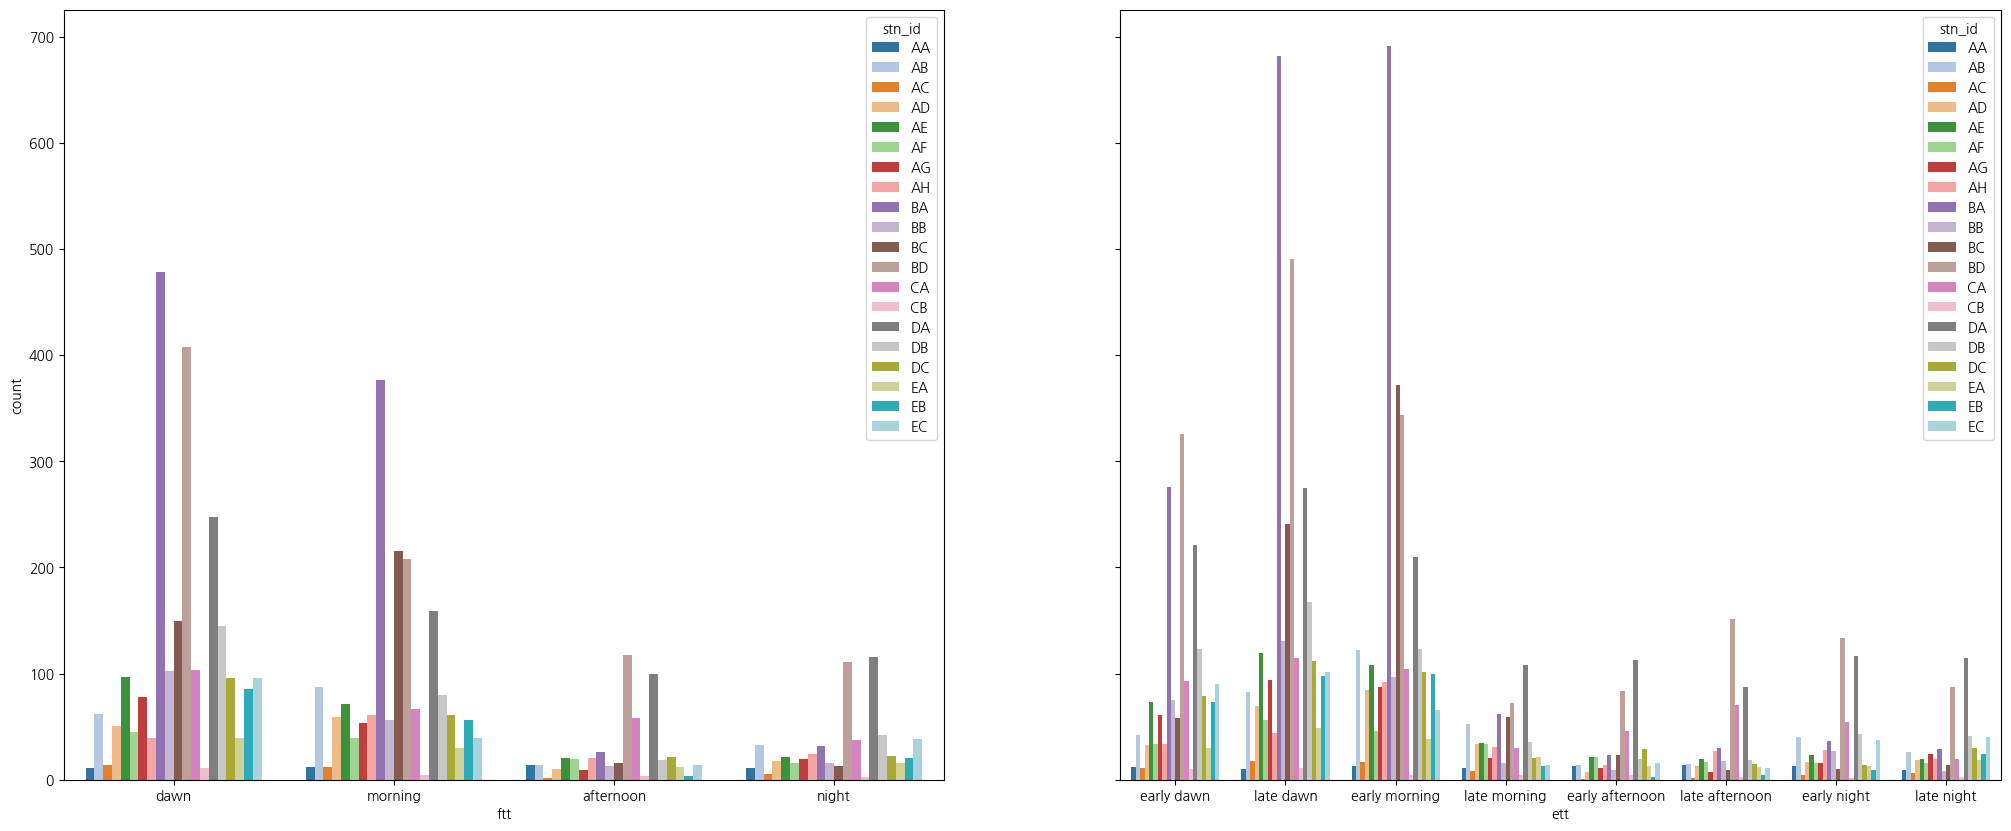

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey='row')
sns.barplot(count_df, x="ftt", y="count", hue="stn_id", errorbar=None, ax=axes[0], palette='tab20')
sns.barplot(count_df, x="ett", y="count", hue="stn_id", errorbar=None, ax=axes[1], palette='tab20')

# cos 시간을 사용하면 dawn과 morning 시간대를 강조할 수 있지 않을까?
# 시간대에 weight를 두자

In [34]:
I_counts = []
for i in range(0, 20 + 1):
    I_counts.append([i*1000, train_I.loc[train_I["vis1_diff"].abs() >= i*1000, :].shape[0], train_I.loc[train_I["vis1_diff"].abs() >= i*1000, :].shape[0] / train_I.shape[0] * 100])

In [35]:
I_counts_df = pd.DataFrame(I_counts, columns = ["limit_vis1_diff", "vis1_diff_count","persent"])

In [36]:
I_counts_df

,limit_vis1_diff,vis1_diff_count,persent
0,0,1043422,98.990760
1,1000,258967,24.568526
2,2000,142758,13.543631
3,3000,87200,8.272774
4,4000,56767,5.385557
5,5000,38756,3.676831
6,6000,27096,2.570632
7,7000,19520,1.851887
8,8000,14635,1.388441
9,9000,11193,1.061894


<Axes: title={'center': 'vis1_diff 절댓값의 최댓값에 따른 I년도에서의 비율'}, xlabel='limit_vis1_diff', ylabel='persent'>

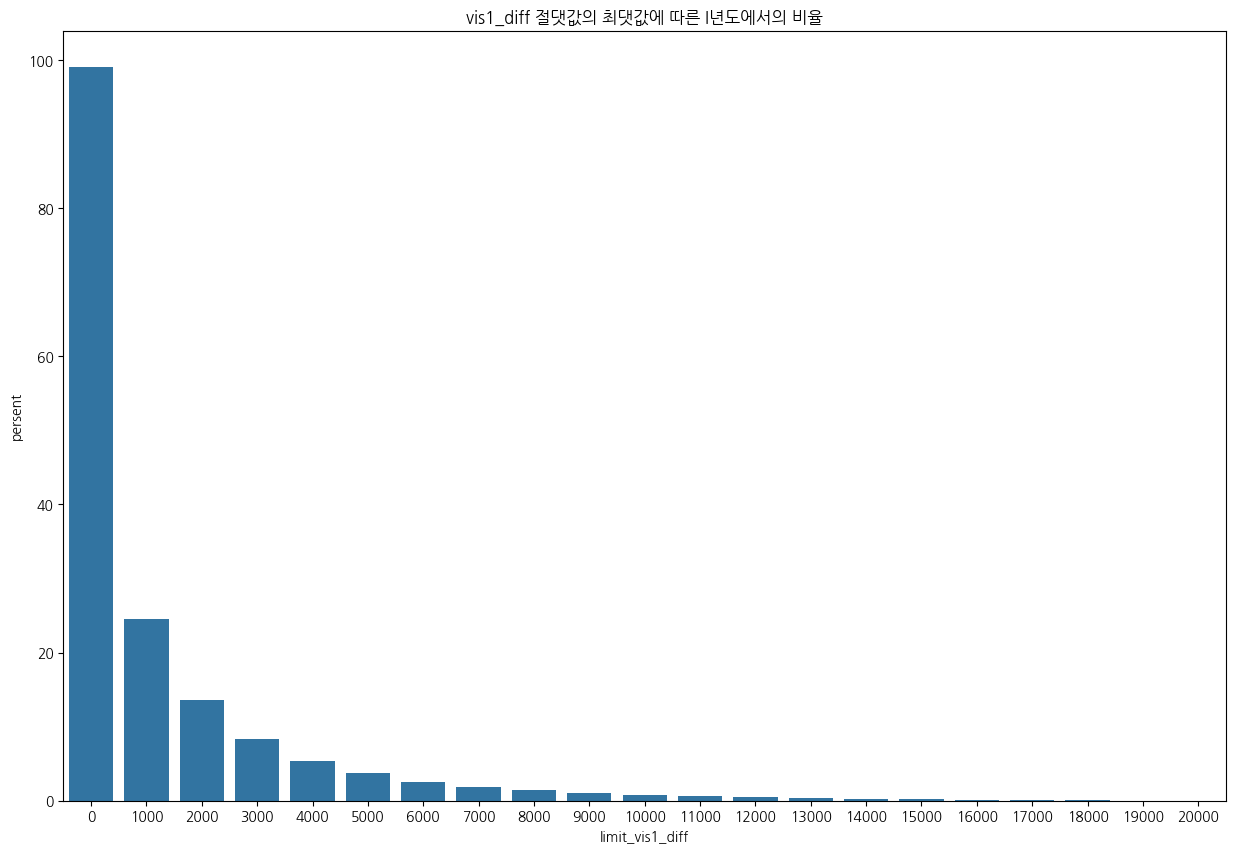

In [37]:
plt.figure(figsize=(15, 10))
plt.title("vis1_diff 절댓값의 최댓값에 따른 I년도에서의 비율")
sns.barplot(I_counts_df, x="limit_vis1_diff", y="persent")

In [38]:
all_counts = []
for i in range(0, 20 + 1):
    all_counts.append([i*1000, train.loc[train["vis1_diff"].abs() >= i*1000, :].shape[0], train.loc[train["vis1_diff"].abs() >= i*1000, :].shape[0] / train.shape[0] * 100])

In [39]:
all_counts_df = pd.DataFrame(all_counts, columns = ["limit_vis1_diff", "vis1_diff_count","persent"])
all_counts_df

,limit_vis1_diff,vis1_diff_count,persent
0,0,3128374,99.110206
1,1000,670853,21.253334
2,2000,373294,11.826350
3,3000,231136,7.322634
4,4000,153186,4.853095
5,5000,106132,3.362374
6,6000,75609,2.395373
7,7000,55502,1.758362
8,8000,42067,1.332727
9,9000,32548,1.031155


<Axes: title={'center': 'vis1_diff 절댓값의 최댓값에 따른 전체 비율'}, xlabel='limit_vis1_diff', ylabel='persent'>

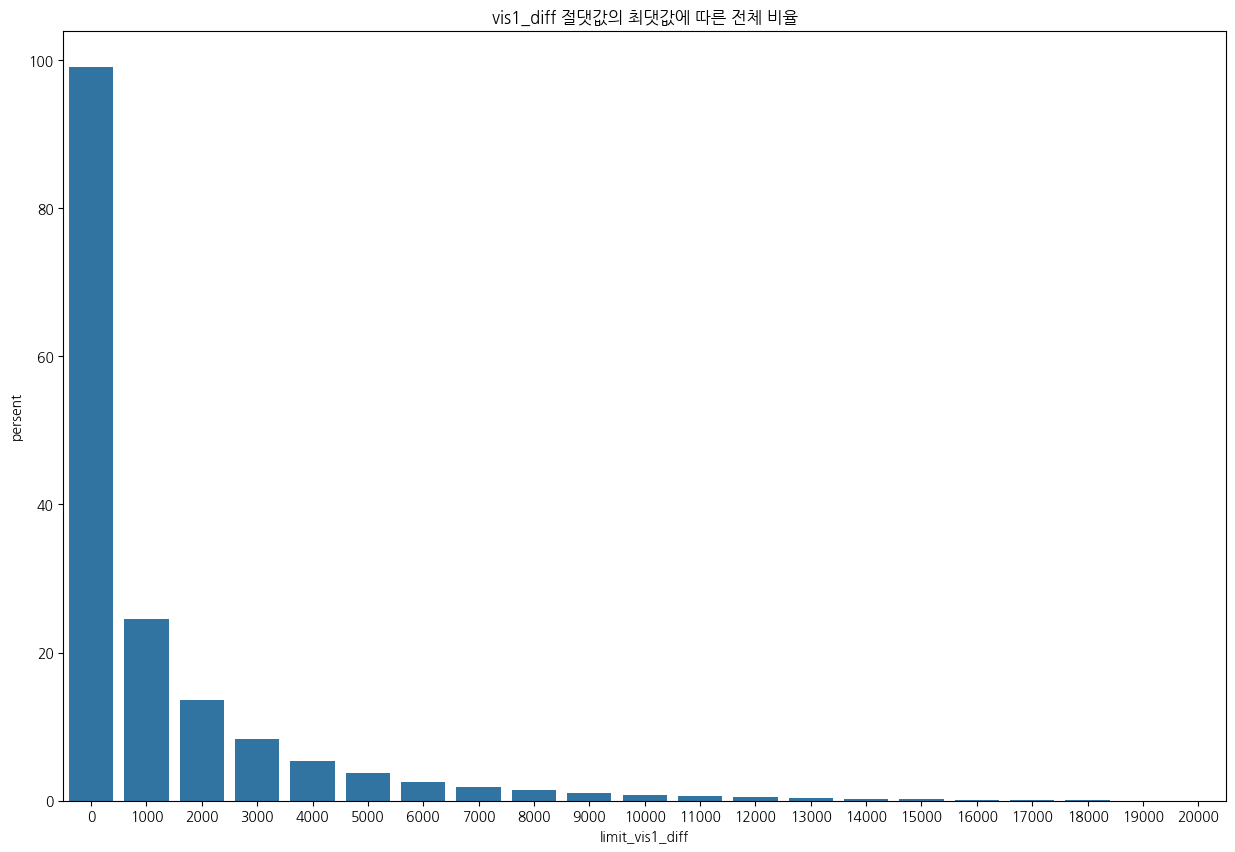

In [40]:
plt.figure(figsize=(15, 10))
plt.title("vis1_diff 절댓값의 최댓값에 따른 전체 비율")
sns.barplot(I_counts_df, x="limit_vis1_diff", y="persent")

In [41]:
train_I[("2020-03-29 12:00:00" <= train_I["datetime"]) & (train_I["datetime"] <= "2020-03-29 14:00:00") & (train_I["stn_id"] == "AH")][["datetime", "ws10_deg", "ws10_ms", "ta", "re", "hm", "sun10", "ts", "vis1", "vis1_diff", "ett"]]

# 이른 오전(12시에서 1시에) 환경이 급격하게 변화한 것이 없음에도 시정의 급격한 변화가 나타남 -> 시정의 이상치 일 가능성이 높음
# 따라서 maximum 시정을 20000으로 놓고 19000 이상의 시정의 급격한 변화를 이상치로 간주 -> 보정 작업 실시
# vis1(시정거리)와 class가 맞지 않는 데이터도 존재

# 갑자기 시정거리가 내려가는건 안개 발생의 여부일 수 있지 않을까??? 
# 내려갔다가 10분만에 다시 올라가는거면 좀 그렇지만 내려갔다가 조금씩 감소하다가 다시 올라가는거면?? 정상 일 수 있지 않을까?

,datetime,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,vis1_diff,ett
381664,2020-03-29 12:00:00,138.5,2.1,12.9,0.0,32.8,0.54,24.4,NaN,NaN,early afternoon
381665,2020-03-29 12:10:00,176.8,3.0,13.3,0.0,32.1,0.55,24.0,20000.0,NaN,early afternoon
381666,2020-03-29 12:20:00,209.4,2.0,14.4,0.0,31.2,0.55,24.6,20000.0,0.0,early afternoon
381667,2020-03-29 12:30:00,163.6,2.4,13.8,0.0,31.7,0.56,24.6,3186.0,-16814.0,early afternoon
381668,2020-03-29 12:40:00,198.1,2.1,14.1,0.0,28.4,0.55,24.8,20000.0,16814.0,early afternoon
381669,2020-03-29 12:50:00,130.4,2.4,14.5,0.0,29.6,0.55,25.6,20000.0,0.0,early afternoon
381670,2020-03-29 13:00:00,112.5,2.2,13.9,0.0,30.7,0.55,25.8,784.0,-19216.0,early afternoon
381671,2020-03-29 13:10:00,116.8,2.5,14.7,0.0,30.4,0.56,26.4,865.0,81.0,early afternoon
381672,2020-03-29 13:20:00,287.0,1.0,14.8,0.0,31.4,0.55,26.8,3150.0,2285.0,early afternoon
381673,2020-03-29 13:30:00,169.9,2.0,15.1,0.0,29.3,0.54,26.7,20000.0,16850.0,early afternoon


In [ ]:
plot_data = train_I.loc[(train_I["stn_id"]=="AA"), :]
fig2 = px.line(data_frame=plot_data, x="datetime", y="ws10_deg_diff", color="ftt", markers=True)
fig2

In [44]:
plot_data[plot_data["ws10_deg_diff"].abs() > 300][["datetime", "ws10_deg", "ws10_deg_diff"]]

,datetime,ws10_deg,ws10_deg_diff
444,2020-01-04 02:10:00,14.4,-344.2
552,2020-01-04 20:10:00,318.0,300.1
556,2020-01-04 20:50:00,349.1,343.4
557,2020-01-04 21:00:00,4.6,-344.5
558,2020-01-04 21:10:00,320.0,315.4
...,...,...,...
52157,2020-12-28 05:00:00,338.0,312.9
52192,2020-12-28 10:50:00,330.7,324.5
52222,2020-12-28 15:50:00,333.2,320.2
52320,2020-12-29 08:10:00,342.3,315.7


In [45]:
plot_data[("2020-01-04 02:00:00" <= plot_data["datetime"]) & (plot_data["datetime"] <= "2020-01-04 03:00:00")][["datetime", "ws10_deg", "ws10_deg_diff"]]

# 각도를 sin, cos 각도로 만들어서 주기를 만들어주자! (라디안으로 바꾸는것도?)

,datetime,ws10_deg,ws10_deg_diff
443,2020-01-04 02:00:00,358.6,98.6
444,2020-01-04 02:10:00,14.4,-344.2
445,2020-01-04 02:20:00,24.0,9.6
446,2020-01-04 02:30:00,31.2,7.2
447,2020-01-04 02:40:00,44.0,12.8
448,2020-01-04 02:50:00,54.7,10.7
449,2020-01-04 03:00:00,43.4,-11.3


In [ ]:
plot_data = train_I.copy()
fig3_1 = px.line(data_frame=plot_data, x="datetime", y="ta_diff", color="stn_id", markers=True)
fig3_1

# 얘는 이상치 데이터 구지구지 화질구지 건드릴 필요 없다. -> 평균기온이 급강하 하는 것은 태양 빛을 구름이 가린 흐린 상황이 발생했을 가능성이 존재

In [ ]:
plot_data = train_J.copy()
fig3_2 = px.line(data_frame=plot_data, x="datetime", y="ta_diff", color="stn_id", markers=True)
fig3_2


In [ ]:
plot_data = train_K.copy()
fig3_3 = px.line(data_frame=plot_data, x="datetime", y="ta_diff", color="stn_id", markers=True)
fig3_3

# 얜 확실히 이상치가 맞다..
# 아무리 평균온도고 기상에 따라 바뀔 순 있을 지언정 5도 이상의 변화는 상식적으로 불가능할 것 같다 따라서 maximum을 5도로 잡고 결측치를 처리한다.

In [ ]:
train_I.loc[train["stn_id"]=='AG', :]

In [ ]:
train[train["ta_diff"].abs() > 10][["datetime", "stn_id", "ta", "ta_diff"]]

In [ ]:
train[("2024-06-10 09:00:00" <= train["datetime"]) & (train["datetime"] <= "2024-06-10 09:40:00") & (train["stn_id"]=="AD")][["datetime", "ta", "re", "sun10","ta_diff"]]

In [ ]:
all_counts = []
for i in np.arange(0.0, 10.0+1, 1):
    all_counts.append([i, train.loc[train["ta_diff"].abs() >= i, :].shape[0], train.loc[train["ta_diff"].abs() >= i, :].shape[0] / train.shape[0] * 100])
    
all_counts_df = pd.DataFrame(all_counts, columns = ["limit_ta_diff", "ta_diff_count","persent"])
all_counts_df

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("ta_diff 절댓값의 최댓값에 따른 전체 비율")
sns.barplot(all_counts_df, x="limit_ta_diff", y="persent")

In [ ]:
plot_data = train_I.copy()
fig4_1 = px.line(data_frame=plot_data, x="datetime", y="hm_diff", color="stn_id", markers=True)
fig4_1

In [ ]:
plot_data = train_J.copy()
fig4_2 = px.line(data_frame=plot_data, x="datetime", y="hm_diff", color="stn_id", markers=True)
fig4_2

In [ ]:
plot_data = train_K.copy()
fig4_3 = px.line(data_frame=plot_data, x="datetime", y="hm_diff", color="stn_id", markers=True)
fig4_3

In [ ]:
train[train["hm_diff"].abs() > 30.0][["datetime", "hm", "hm_diff", "re", "class"]]

# 기상청 데이터로 미루어보아 2~30% 정도의 변화는 발생하는 것 같다. 상대 습도가 100 인 경우도 존재하는 것 같다. 기상청 데이터(1시간 단위)를 살펴본 결과 0인 결과는 없다. 1시간 결과라서 그런지 습도의 변화량이 크다. 10분 간격이면?!
# 일단 상대습도가 0인 경우만 NaN으로 바꾸자

In [ ]:
train[train["hm"]==100.0][["datetime", "hm", "hm_diff", "re", "class"]]

# 상대습도가 0인 경우는 1개 존재

In [ ]:
plot_data[("2020-05-28 20:00:00" <= plot_data["datetime"]) & (plot_data["datetime"] <= "2020-05-28 21:00:00")][["datetime", "hm", "re", "sun10","hm_diff"]]

In [ ]:
# 'sun10'
# late night -> 21시~00시(다 0으로 처리), early dawn -> 00시~03시(다 0으로 처리), late dawn -> 03시~06시(여름만 제외하고 0으로 처리)

plot_data = train_I.loc[(train_I["stn_id"]=="AA"), :]
fig4 = px.line(data_frame=plot_data, x="datetime", y="sun10_diff", color="ett", markers=True)
fig4

In [ ]:
# 'ts', 'vis1'

plot_data = train_I.copy()
fig5 = px.line(data_frame=plot_data, x="datetime", y="ts_diff", color="stn_id", markers=True)
fig5

In [ ]:
plot_data[plot_data["ts_diff"].abs() > 10.0][["datetime", "ts", "ts_diff"]]

# 기준 차분 절댓값 10이상인 것들 결측 처리

In [ ]:
plot_data[("2020-04-10 12:00:00" <= plot_data["datetime"]) & (plot_data["datetime"] <= "2020-04-10 16:00:00")][["datetime", "ts", "re", "sun10","ts_diff"]]

# ts에 0인 값들이 존재함 -> 결측처리, => 겨울에 ts가 어떤지 확인 필수

In [ ]:
# 'vis1'

plot_data = train_I.loc[(train_I["stn_id"]=="AA"), :]
fig6 = px.line(data_frame=plot_data, x="datetime", y="vis1_diff", color="ftt", markers=True)
fig6

In [ ]:
plot_data[plot_data["vis1_diff"].abs() > 19000][["datetime", "vis1", "vis1_diff"]]

# 기준 차분 절댓값 10이상인 것들 결측 처리

In [ ]:
plot_data.columns

In [ ]:
plot_data[("2020-10-28 18:30:00" <= plot_data["datetime"]) & (plot_data["datetime"] <= "2020-10-28 19:30:00")][["datetime", "vis1", "hm", "ws10_ms", "sun10","vis1_diff"]]